In [1]:
import warnings
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn import linear_model
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import resample
from scipy.stats import ttest_ind

warnings.filterwarnings('ignore')

In [2]:
import tensorflow_federated as tff
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

In [3]:
df = pd.read_csv('credit.csv')
df.head()

,id,y,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,62555,0,-1.059625,-0.063793,-0.016145,-0.057852,0.237202,-0.024016,2.281696,-0.100419,-0.173079,-0.186066
1,108651,0,-0.476640,-0.063793,-0.016145,-0.057852,-0.666126,-0.023901,1.401642,-0.100419,0.556477,-0.406640
2,69272,0,1.077985,-0.063793,1.754131,-0.057852,1.140530,-0.022187,0.318498,-0.100419,-0.172760,0.581801
3,122154,0,-0.865297,-0.063793,-0.901283,-0.057852,1.140530,-0.023753,-0.696949,-0.100419,-0.173209,-0.216555
4,83494,0,-1.253953,-0.063793,-0.901283,-0.057852,-0.666126,-0.023336,0.386194,-0.100419,-0.173158,-0.300193


In [4]:
print(df[df.y == 0].shape[0], df[df.y == 1].shape[0])

139974 10026


The data are highly unbalanced - a model outputing 0 all the time would get a reasonable score. downsample the dominant class (0) to match number of instances of class 1.

In [5]:
downsampled_0 = resample(df[df.y == 0], replace=False, n_samples=df[df.y == 1].shape[0], random_state=1337)
df = pd.concat([downsampled_0, df[df.y == 1]])

In [ ]:
Hold back 1/3 of data to test on.

## Setup testing environment
Assign x, y data to a number of siloed partitions ("runners") with skew. the skew is a measure of "non iidness'.

- skew = 0: the data are uniformaly distributed between runners
- skew = 0.1: a runner will hold a minimum of 10% of labels for a class.
- skew = 1: a runner will hold all labels for a class.
- remaining labels are uniformaly distributed.

In [6]:
x = df.to_numpy()
X = x[:,2:]
y = x[:,1]
n_features = X.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=1337)

In [7]:
def label_distribution_skew(x, y, partitions, skew=1):
    def runner_split(N_labels, N_runners):
        """number of labels to assign to n runners"""
        runner_labels = round(max(1, N_labels / N_runners))
        runner_split = round(max(1, N_runners / N_labels))
        return runner_labels, runner_split

    runner_data = []
    N_labels = np.unique(y).shape[0]
    n_labels, n_runners = runner_split(N_labels, partitions)
    
    runner_idx = 0
    for label_idx in range(0, N_labels, n_labels):
        mask = np.isin(y, range(label_idx, label_idx+n_labels))
        subset_idx = np.argwhere(mask)[:, 0]
        n_samples = subset_idx.shape[0]
        sample_size = math.floor(skew*n_samples)
        subset_idx = np.random.choice(subset_idx, sample_size, replace=False)
        x_subset = x[subset_idx, ]
        y_subset = y[subset_idx]   
    
        for partition in zip(np.array_split(x_subset, n_runners),
                             np.array_split(y_subset, n_runners)):
            runner_data.append(partition)
    
        x = np.delete(x, subset_idx, axis=0)
        y = np.delete(y, subset_idx)    
        runner_idx = runner_idx + n_runners

    return runner_data, x, y

Distribute data uniformaly between runners

In [8]:
def uniform_distribution(x, y, partitions, randomise=True):
    runner_data = []
    rows = x.shape[0]
    i = np.arange(rows)
    if randomise:
        np.random.shuffle(i)
    for partition in zip(np.array_split(x[i, ], partitions),
                         np.array_split(y[i], partitions)):
        runner_data.append(partition)
    return runner_data

Parition data using label skew ^

In [9]:
def partition(x, y, partitions, randomise=True, skew=1):
    skewed_data, x_remain, y_remain = label_distribution_skew(x, y, partitions, skew)
    uniform_data = uniform_distribution(x_remain, y_remain, partitions, randomise)

    for i, skew_partition in enumerate(skewed_data):
        x_partition = np.concatenate((uniform_data[i][0], skew_partition[0]))
        y_partition = np.concatenate((uniform_data[i][1], skew_partition[1]))
        if randomise:
            i = np.arange(y_partition.shape[0])
            np.random.shuffle(i)
            x_partition = x_partition[i, ]
            y_partition = y_partition[i]
        yield x_partition, y_partition

Example of label skew. here, there are 10 runners and 2 labels. the data are paritioned with "90% non iid/label skew". counts indicate the number of instances for each label, per runner.

In [10]:
for i, (runner_x, runner_y) in enumerate(partition(X_train, y_train, partitions=10, randomise=True, skew=0.9)):
    print("runner {:02d} -> {}".format(i+1, np.unique(runner_y, return_counts=True)))

runner 01 -> (array([0., 1.]), array([1267,   73], dtype=int64))
runner 02 -> (array([0., 1.]), array([1272,   67], dtype=int64))
runner 03 -> (array([0., 1.]), array([1276,   63], dtype=int64))
runner 04 -> (array([0., 1.]), array([1266,   73], dtype=int64))
runner 05 -> (array([0., 1.]), array([1279,   60], dtype=int64))
runner 06 -> (array([0., 1.]), array([  68, 1267], dtype=int64))
runner 07 -> (array([0., 1.]), array([  64, 1271], dtype=int64))
runner 08 -> (array([0., 1.]), array([  69, 1266], dtype=int64))
runner 09 -> (array([0., 1.]), array([  69, 1265], dtype=int64))
runner 10 -> (array([0., 1.]), array([  66, 1267], dtype=int64))


Set the weights of a scikit-learn model.

In [11]:
def set_weights(intercept, coef, classes, model=linear_model.SGDClassifier()):
    model.intercept_ = intercept
    model.coef_ = coef
    model.classes_ = classes
    return model

Split a dataset into batches with optional instance randomisation.

In [12]:
def batches(X, y, batch_size, randomise):
    rows = X.shape[0]
    i = np.arange(rows)
    if randomise:
        np.random.shuffle(i)
    splits = rows / batch_size
    for x_batch, y_batch in zip(np.array_split(X[i, ], splits),
                                np.array_split(y[i], splits)):
        yield x_batch, y_batch

For each batch, update model weights.

In [13]:
def batch_update(model, X, y, classes, batch_size, randomise):
    if batch_size is None:
        batch_size = X.shape[0]
    for x_batch, y_batch in batches(X, y, batch_size, randomise):
        model.partial_fit(x_batch, y_batch, classes)
    return model.intercept_, model.coef_

Apply weight updates for each epoch.

In [14]:
def batch_train(model, X, y, classes, epochs, batch_size, randomise):
    for _ in range(0, epochs):
        batch_update(model, X, y, classes, batch_size, randomise)

Given starting weights, train a model.

In [15]:
def train_model(intercept_init, coef_init, X, y, epochs, lr, batch_size=None, randomise=True):
    if batch_size is None or batch_size <= 0:
        batch_size = X.shape[0]
    classes = np.unique(y)
    model = linear_model.SGDClassifier(loss='log', learning_rate='constant', eta0=lr, verbose=0)
    set_weights(intercept_init, coef_init, classes, model)
    batch_train(model, X, y, classes, epochs, batch_size, randomise)
    return model

A runner encapsulates a data-silo and generates models from it's data.

In [16]:
class Runner:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def optimise(self, intercept_init, coef_init, hyperparameters):
        _intercept_init = intercept_init.copy()
        _coef_init = coef_init.copy()
        model = train_model(_intercept_init, _coef_init, self.X, self.y, **hyperparameters)
        return model
        
    def dataset_size(self):
        return self.X.shape[0]

Initialise a set of runners and partition the data according to some scheme.

In [17]:
def init_runners(X, y, n_runners, scheme='uniform', args=None):
    partitions = None
    if scheme == 'uniform':
        partitions = zip(np.array_split(X, n_runners), np.array_split(y, n_runners))
    elif scheme == 'label-skew':
        partitions = partition(X, y, partitions=n_runners, randomise=args['randomise'], skew=args['skew'])
    else:
        raise Exception("partitioning scheme not supported")
    
    return [Runner(x, y) for x, y in partitions]

FederatedAveraging algorithm wrapped as a scikit-learn model. Note it is possible to perform recurrent federated averaging (federated averaging of federated averaging).

In [18]:
class FedAvg(BaseEstimator, ClassifierMixin):
    
    def __init__(self,
                 n_runners=1,
                 sample_size=1,
                 rounds=1,
                 combine='weighted',
                 partition_params={
                     'scheme': 'uniform'
                 },
                 runner_hyperparams={
                    'epochs': 1,
                    'lr': 0.15,
                    'batch_size': 0
                 },
                 intercept_init=None,
                 coef_init=None):
       
        self.intercept_ = intercept_init
        self.coef_ = coef_init
        
        self.n_runners = n_runners
        self.sample_size = sample_size
        self.rounds = rounds
        self.combine = combine
        
        self.partition_params = partition_params
        self.runner_hyperparams = runner_hyperparams
        
        self.models = []
       
    def _collect_models(self, runners, N):
        r_intercepts, r_coefs, r_weights = [], [], []
        self.models = []
        for runner in random.sample(runners, k=self.sample_size):
            r_model = runner.optimise(self.intercept_, self.coef_, self.runner_hyperparams)
            self.models.append(r_model)
            r_intercepts.append(r_model.intercept_)
            r_coefs.append(r_model.coef_)
            r_weights.append(runner.dataset_size()/N if self.combine == 'weighted' else 1/self.sample_size)
        return r_intercepts, r_coefs, r_weights
        
    
    def fit(self, X, y):
        if self.intercept_ is None or self.coef_ is None:
            features = X.shape[1]
            self.intercept_ = np.zeros(1)
            self.coef_ = np.zeros((1, features))
        
        N = X.shape[0]
        runners = init_runners(X, y, self.n_runners, **self.partition_params)
        
        for _ in range(self.rounds):
            r_intercepts, r_coefs, r_weights = self._collect_models(runners, N)
            self.intercept_ = np.average(r_intercepts, axis=0, weights=r_weights)
            self.coef_ = np.average(r_coefs, axis=0, weights=r_weights)
        
        self.global_model = set_weights(self.intercept_, self.coef_, np.unique(y))
        return self

    def predict(self, X):
        if not hasattr(self, 'global_model'):
            raise Exception("model not trained")
        return self.global_model.predict(X)

## Test/run-through

Training using FederatedAveraging

In [19]:
hyperparams = {
    'n_runners': 10,
    'sample_size': 5,
    'rounds': 100,
    'combine': 'weighted', # or 'mean'
    'partition_params': {
        'scheme': 'uniform' # stratified, non-iidness, noise injection etc.
    },
    'runner_hyperparams': {
        'epochs': 1,
        'lr': 0.15,
        'batch_size': 0
    }
}

fed_avg = FedAvg(**hyperparams)
fed_avg.fit(X_train, y_train)
preds = fed_avg.predict(X_test)

print(classification_report(y_test, preds, target_names=['class_0', 'class_1']))
print(fed_avg.intercept_)
print(fed_avg.coef_)

              precision    recall  f1-score   support

     class_0       0.68      0.62      0.65      3330
     class_1       0.65      0.71      0.68      3354

    accuracy                           0.66      6684
   macro avg       0.66      0.66      0.66      6684
weighted avg       0.66      0.66      0.66      6684

[-0.13473949]
[[ 0.21268152  1.64408828  0.11219933 -0.73898476  0.10877692  0.1733609
  -0.51467517  1.74937561 -0.79545895 -0.39635155]]


In [39]:
def grid_search_trials(params, trials, x, y, param='sample_size'):
    best = []
    for i in tqdm(range(trials), desc="trial"):
        clf = GridSearchCV(FedAvg(), params, scoring='f1')
        clf.fit(x, y)
        best_model = clf.best_estimator_
        best.append(clf.best_params_[param])
    values, counts = np.unique(best, return_counts=True)
    return values, counts

### Under what conditions does FedAvg perform well?
What is the performance of the fedavg model vs the best performing locally trained model?

Train a FedAvg model, test it over hold-out-data, get F1 score.
Test it's local models on hold-out data, store average F1 score.
Repeat 100 times to get a sample.

In [42]:
hyperparams = {
    'n_runners': 10,
    'sample_size': 10,
    'rounds': 1,
    'combine': 'weighted', # or 'mean'
    'partition_params': {
        'scheme': 'uniform' # stratified, non-iidness, noise injection etc.
    },
    'runner_hyperparams': {
        'epochs': 10,
        'lr': 0.15,
        'batch_size': 0
    }
}

local_mean_f1_scores = []
local_max_f1_scores = []
fed_avg_f1_scores = []

for i in tqdm(range(0, 100), desc="trial"):
    fed_avg = FedAvg(**hyperparams)
    fed_avg.fit(X_train, y_train)
    preds = fed_avg.predict(X_test)
    fed_avg_f1_scores.append(f1_score(y_test, preds, average='weighted'))
    tmp = []
    for model in fed_avg.models:
        local_pred = model.predict(X_test)
        tmp.append(f1_score(y_test, local_pred, average='weighted'))
    local_mean_f1_scores.append(np.mean(tmp))
    local_max_f1_scores.append(np.max(tmp))
    
print("local mean models = ", np.mean(local_mean_f1_scores))
print("local max models = ", np.mean(local_max_f1_scores))
print("fedAvg model = ", np.mean(fed_avg_f1_scores))

trial:   0%|          | 0/100 [00:00<?, ?it/s]

local mean models =  0.6812136024080935
local max models =  0.7262090464185345
fedAvg model =  0.7253226309335361


With uniform/iid data, FedAvg outperforms locally trained models on average. This shows the distribution of FedAvg F1 scores (orange) vs the distribution of (average) locally trained models F1 score.

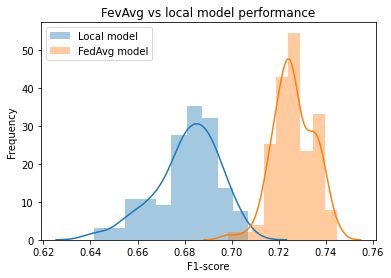

In [43]:
fig, ax = plt.subplots()
ax.set(xlabel='F1-score', ylabel='Frequency')
ax.set_title('FevAvg vs local model performance')
sns.distplot(local_mean_f1_scores, ax=ax, kde=True, label="Local model")
sns.distplot(local_max_f1_scores, ax=ax, kde=True, label="FedAvg model")
ax.legend()
#fig.savefig('/tmp/x1.png')

On average, the FedAvg model is as good as the best perfoming locally trained model.

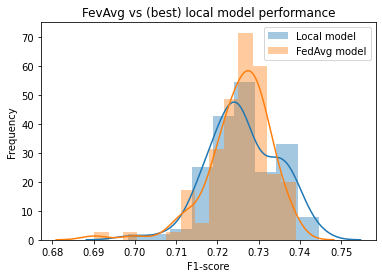

In [44]:
fig, ax = plt.subplots()
ax.set(xlabel='F1-score', ylabel='Frequency')
ax.set_title('FevAvg vs (best) local model performance')
sns.distplot(local_max_f1_scores, ax=ax, kde=True, label="Local model")
sns.distplot(fed_avg_f1_scores, ax=ax, kde=True, label="FedAvg model")
ax.legend()

### How robust is FedAvg to non-iid data?
- Run FedAvg over different levels of label skew.
- See how it compares to locally trained models

In [23]:
def compare_f1(hyperparams, rounds=1):
    local_mean_f1_scores = []
    local_max_f1_scores = []
    fed_avg_f1_scores = []
    #for i in tqdm(range(0, rounds), desc="round", leave=False):
    for i in range(0, rounds):
        fed_avg = FedAvg(**hyperparams)
        fed_avg.fit(X_train, y_train)
        preds = fed_avg.predict(X_test)
        fed_avg_f1_scores.append(f1_score(y_test, preds, average='weighted'))
        tmp = []
        for model in fed_avg.models:
            local_pred = model.predict(X_test)
            tmp.append(f1_score(y_test, local_pred, average='weighted'))
        local_mean_f1_scores.append(np.mean(tmp))
        local_max_f1_scores.append(np.max(tmp))
    return np.mean(local_mean_f1_scores), np.mean(local_max_f1_scores), np.mean(fed_avg_f1_scores)

In [24]:
skews = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
scores = {}

for skew in skews:
    print(f"skew level = {skew}")
    hyperparams = {
        'n_runners': 10,
        'sample_size': 10,
        'rounds': 1,
        'combine': 'weighted', # or 'mean'
        'partition_params': {
            'scheme': 'label-skew', # uniform, label-skew
            'args': {
                'randomise': True,
                'skew': skew
            }
        },
        'runner_hyperparams': {
            'epochs': 10,
            'lr': 0.15,
            'batch_size': 0
        }
    }
    local_mean_f1_scores, local_max_f1_scores, fed_avg_f1_scores = compare_f1(hyperparams, 10)
    scores[str(skew)] = (local_mean_f1_scores, local_max_f1_scores, fed_avg_f1_scores)

skew level = 0
skew level = 0.1
skew level = 0.2
skew level = 0.3
skew level = 0.4
skew level = 0.5
skew level = 0.6
skew level = 0.7
skew level = 0.8
skew level = 0.9
skew level = 0.99


In [25]:
local_mean_f1_scores = [score[0] for score in scores.values()]
local_max_f1_scores = [score[1] for score in scores.values()]
fed_avg_f1_scores = [score[2] for score in scores.values()]

Above, we obtained the performance of our FedAvg model vs the mean performance of the local models used to create the FedAvg model for increasing levels of label skew. If we were able to access all of the data, the performance of our model would be equivalent to a FedAvg model trained on an IID/non skewed dataset

In [26]:
centralised_model = [fed_avg_f1_scores[0]]*len(fed_avg_f1_scores)

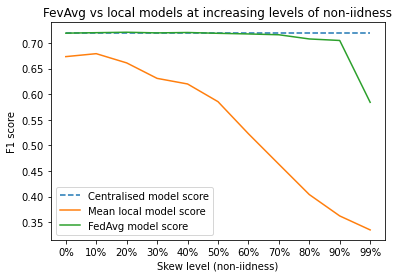

In [28]:
x_labels = ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '99%']
fig, ax = plt.subplots()
ax.set(xlabel='Skew level (non-iidness)', ylabel='F1 score')
ax.set_title('FevAvg vs local models at increasing levels of non-iidness')
sns.lineplot(x=x_labels, y=centralised_model, ax=ax, label='Centralised model score')
sns.lineplot(x=x_labels, y=local_mean_f1_scores, ax=ax, label='Mean local model score')
sns.lineplot(x=x_labels, y=fed_avg_f1_scores, ax=ax, label='FedAvg model score')
ax.lines[0].set_linestyle("--")
ax.legend()
#fig.savefig('/tmp/x.png')

The above plot shows that FedAvg (green) consistently outperforms locally trained models under varying degrees of label distribution skew.

- FedAvg always outperforms the average F1 score from locally trained models (blue)
- Up until ~40% label skew, the best locally trained model is on-par with the FedAvg model. After this point, FedAvg clearly has an advantage - consistently outperforming with a gradual decrease in performance (by comparison with local models) as the level of non-iidness is increased.